# Обученме модели определения ключевых точек руки

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import timm

import json
from glob import glob

import json
import cv2
import numpy as np
from glob import glob
import numpy as np
import cv2

from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
images_paths = glob("FreiHAND_pub_v2/training/rgb/*")[:32560]

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

batch_size = 64

In [4]:
#For Training
def load_json_files(path = 'FreiHAND_pub_v2/'):
    with open(f'{path}/training_K.json') as K_fp, open(f'{path}/training_verts.json') as verts_fp, open(f'{path}/training_xyz.json') as xyz_fp:
        K_array = json.load(K_fp)
        verts_array = json.load(verts_fp)
        xyz_array = json.load(xyz_fp)
        
        return K_array, verts_array, xyz_array
    
def projectPoints(xyz, K):
    """ Project 3D coordinates into image space. """
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]

def renderPose(img, uv):
    connections = [[0,1], [1,2], [2,3], [3,4], 
                   [0,5], [5,6], [6,7], [7,8], 
                   [0,9], [9,10],[10,11], [11,12],
                   [0,13],[13,14], [14,15], [15,16], 
                   [0,17],[17,18], [18,19], [19,20]]
    for c in connections:
        img = cv2.line(img,uv[c[0]],uv[c[1]],(255,0,0),2)
        
    for point in uv:
        img = cv2.circle(img, point, 2, (0,0,255), -1)
        
    return img

In [5]:
def oks(y_true, y_pred, visibility):
    # You might want to set these global constant
    # outside the function scope
    KAPPA = np.array([1] * len(y_true))
    # The object scale
    # You might need a dynamic value for the object scale
    SCALE = 1.0

    # Compute the L2/Euclidean Distance
    distances = np.linalg.norm(y_pred - y_true, axis=-1)
    # Compute the exponential part of the equation
    exp_vector = np.exp(-(distances**2) / (2 * (SCALE**2) * (KAPPA**2)))
    # The numerator expression
    numerator = np.dot(exp_vector, visibility.astype(bool).astype(int))
    # The denominator expression
    denominator = np.sum(visibility.astype(bool).astype(int))
    return numerator / denominator

In [6]:
K_array, verts_array, xyz_array = load_json_files()

In [7]:
keypoints = []
for index, image_path in enumerate(tqdm(images_paths)):
    # Read image from path
    image_arr = cv2.imread(image_path)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)

    # Geting dots coordinates
    image_height, image_width, _ = image_arr.shape
    uv = projectPoints(xyz_array[index], K_array[index]).astype(np.int32)

    # Convert to relative coordinates
    relative_points = [[x / image_width, y / image_height] for x, y in uv]
    keypoints.append(relative_points)

100%|██████████| 32560/32560 [07:03<00:00, 76.84it/s]


In [8]:
train_idx, val_idx = [int(i) for i in [len(images_paths) * .7, len(images_paths) * .9]]

In [9]:
data = [(i, k) for i, k in zip(images_paths, keypoints)]

In [10]:
dataset = {"train": data[:train_idx], "val": data[train_idx:val_idx], "test": data[val_idx:]}

In [12]:
class KeypointsDataset(Dataset):

    def __init__(self, meta):
        self.meta = meta
        self.preprocessing = A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name, relative_points = self.meta[idx]
        image = self.preprocessing(image=image_arr)['image']
        return image, torch.Tensor([x * 244 for y in relative_points for x in y])

In [13]:
train_dataset = KeypointsDataset(meta=dataset["train"])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [14]:
val_dataset = KeypointsDataset(meta=dataset["val"])
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
model = timm.create_model('mobilenetv2_050', pretrained=True, num_classes=0)
model.global_pool = nn.Flatten()
model.classifier = nn.Sequential(
    nn.Linear(62720, 42),
    nn.Sigmoid()
)
model.to(device);

In [21]:
# Возьмем предобученную модель и перепишем классификатор 
model_name = 'tf_efficientnetv2_s_in21k'
model = timm.create_model(model_name, pretrained=True).to("cuda")

model
additional_layers = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU()
)
model.classifier = nn.Sequential(
    nn.Linear(256, 42)
)

model.classifier = nn.Sequential(additional_layers, model.classifier)
_ = model.to("cuda")

In [22]:
EPOCHS = 100
lr = 0.001

optimizer = optim.AdamW(model.parameters(), lr)

criterion = nn.MSELoss()

In [ ]:
for epoch in range(EPOCHS):
    
    model.train()
        
    train_loss = []
    train_predictions = []
    train_targets = []
    for batch, targets in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
        optimizer.zero_grad()
        
        batch = batch.to(device)
        targets = targets.to(device)
        
        predictions = model(batch)
        
        loss = criterion(predictions, targets) 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
        predictions = predictions.cpu().detach().numpy().reshape(-1, 3)
        train_predictions.extend(predictions)
        targets = targets.cpu().detach().numpy().reshape(-1, 3)
        train_targets.extend(targets)
    
    train_targets = np.array(train_targets)
    train_predictions = np.array(train_predictions)
    print('Training loss:', np.mean(train_loss))
    print('Train OKS:', oks(train_targets[:, :2], train_predictions[:, :2], train_targets[:, 2]))
    
    model.eval()
        
    val_predictions = []
    val_targets = []
    for batch, targets in tqdm(val_dataloader, desc=f"Epoch: {epoch}"):
        
        with torch.no_grad():
        
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)
            
            predictions = predictions.cpu().numpy().reshape(-1, 3)
            val_predictions.extend(predictions)
            targets = targets.cpu().numpy().reshape(-1, 3)
            val_targets.extend(targets)
        
    val_targets = np.array(val_targets)
    val_predictions = np.array(val_predictions)
    print('Val OKS:', oks(val_targets[:, :2], val_predictions[:, :2], val_targets[:, 2]))

Epoch: 0: 100%|██████████| 713/713 [03:07<00:00,  3.80it/s]


Training loss: 847.2515109839312
Train OKS: 0.001310270123084948


Epoch: 0: 100%|██████████| 204/204 [00:17<00:00, 11.92it/s]


Val OKS: 0.0013784051193189441


Epoch: 1: 100%|██████████| 713/713 [03:07<00:00,  3.80it/s]


Training loss: 591.1047540908107
Train OKS: 0.001304481301801068


Epoch: 1: 100%|██████████| 204/204 [00:16<00:00, 12.00it/s]


Val OKS: 0.0013292805017588506


Epoch: 2: 100%|██████████| 713/713 [03:03<00:00,  3.88it/s]


Training loss: 589.3900016795368
Train OKS: 0.0012824950778635015


Epoch: 2: 100%|██████████| 204/204 [00:15<00:00, 13.57it/s]


Val OKS: 0.001390356103175049


Epoch: 3: 100%|██████████| 713/713 [02:47<00:00,  4.27it/s]


Training loss: 588.6575066993146
Train OKS: 0.0013340267489594802


Epoch: 3: 100%|██████████| 204/204 [00:14<00:00, 14.19it/s]


Val OKS: 0.0009928857518787682


Epoch: 4: 100%|██████████| 713/713 [02:51<00:00,  4.17it/s]


Training loss: 589.7308838404244
Train OKS: 0.0012723920547836574


Epoch: 4: 100%|██████████| 204/204 [00:15<00:00, 13.14it/s]


Val OKS: 0.0013257729935379472


Epoch: 5: 100%|██████████| 713/713 [02:46<00:00,  4.28it/s]


Training loss: 589.3351869302244
Train OKS: 0.0012891502857221393


Epoch: 5: 100%|██████████| 204/204 [00:14<00:00, 13.70it/s]


Val OKS: 0.0013306572104946211


Epoch: 6: 100%|██████████| 713/713 [02:37<00:00,  4.53it/s]


Training loss: 591.5362967428285
Train OKS: 0.0012721385871754022


Epoch: 6: 100%|██████████| 204/204 [00:14<00:00, 13.90it/s]


Val OKS: 0.0009970842129147387


Epoch: 7: 100%|██████████| 713/713 [02:38<00:00,  4.49it/s]


Training loss: 588.8252140168221
Train OKS: 0.0012864116546817345


Epoch: 7: 100%|██████████| 204/204 [00:14<00:00, 13.93it/s]


Val OKS: 0.0010358291690236536


Epoch: 8: 100%|██████████| 713/713 [02:38<00:00,  4.49it/s]


Training loss: 589.111307323397
Train OKS: 0.0013689615559890882


Epoch: 8: 100%|██████████| 204/204 [00:14<00:00, 14.19it/s]


Val OKS: 0.001356483686247063


Epoch: 9: 100%|██████████| 713/713 [02:38<00:00,  4.51it/s]


Training loss: 588.4974985430317
Train OKS: 0.001232697490629835


Epoch: 9: 100%|██████████| 204/204 [00:14<00:00, 13.98it/s]


Val OKS: 0.0013698418568982346


Epoch: 10: 100%|██████████| 713/713 [02:37<00:00,  4.53it/s]


Training loss: 587.7856659748778
Train OKS: 0.0013381379413686045


Epoch: 10: 100%|██████████| 204/204 [00:14<00:00, 14.05it/s]


Val OKS: 0.0013709585707090343


Epoch: 11: 100%|██████████| 713/713 [02:37<00:00,  4.52it/s]


Training loss: 588.1434079206341
Train OKS: 0.0013017646011987672


Epoch: 11: 100%|██████████| 204/204 [00:14<00:00, 14.21it/s]


Val OKS: 0.0012366466951118172


Epoch: 12: 100%|██████████| 713/713 [02:37<00:00,  4.52it/s]


Training loss: 587.0115560609195
Train OKS: 0.0013169818328185145


Epoch: 12: 100%|██████████| 204/204 [00:14<00:00, 14.20it/s]


Val OKS: 0.00120231375831959


Epoch: 13: 100%|██████████| 713/713 [02:37<00:00,  4.53it/s]


Training loss: 586.2945150452945
Train OKS: 0.001249394487852481


Epoch: 13: 100%|██████████| 204/204 [00:14<00:00, 14.04it/s]


Val OKS: 0.0012517054206305956


Epoch: 14: 100%|██████████| 713/713 [03:06<00:00,  3.82it/s]


Training loss: 587.30777157306
Train OKS: 0.0013357094903529232


Epoch: 14: 100%|██████████| 204/204 [00:14<00:00, 13.99it/s]


Val OKS: 0.001408107582519664


Epoch: 15: 100%|██████████| 713/713 [02:37<00:00,  4.52it/s]


Training loss: 587.6664918789857
Train OKS: 0.001368259146012716


Epoch: 15: 100%|██████████| 204/204 [00:14<00:00, 14.11it/s]


Val OKS: 0.0014613958825816214


Epoch: 16: 100%|██████████| 713/713 [02:58<00:00,  3.99it/s]


Training loss: 587.0101385129952
Train OKS: 0.0013339793243155019


Epoch: 16: 100%|██████████| 204/204 [00:16<00:00, 12.21it/s]


Val OKS: 0.0012192278342159104


Epoch: 17: 100%|██████████| 713/713 [03:10<00:00,  3.73it/s]


Training loss: 586.5979589432854
Train OKS: 0.0013114645030629561


Epoch: 17: 100%|██████████| 204/204 [00:17<00:00, 11.79it/s]


Val OKS: 0.0013921919437520996


Epoch: 18: 100%|██████████| 713/713 [03:02<00:00,  3.92it/s]


Training loss: 586.4270730038679
Train OKS: 0.0013077201165125456


Epoch: 18: 100%|██████████| 204/204 [00:15<00:00, 13.51it/s]


Val OKS: 0.0013716972949408895


Epoch: 19: 100%|██████████| 713/713 [02:40<00:00,  4.43it/s]


Training loss: 586.1192707420231
Train OKS: 0.0012727522039472701


Epoch: 19: 100%|██████████| 204/204 [00:14<00:00, 13.85it/s]


Val OKS: 0.0012401812533529893


Epoch: 20: 100%|██████████| 713/713 [03:06<00:00,  3.83it/s]


Training loss: 585.3009057172051
Train OKS: 0.001351995966087266


Epoch: 20: 100%|██████████| 204/204 [00:16<00:00, 12.09it/s]


Val OKS: 0.001152986972517077


Epoch: 21: 100%|██████████| 713/713 [03:20<00:00,  3.55it/s]


Training loss: 586.3092835842309
Train OKS: 0.0013045854728260752


Epoch: 21: 100%|██████████| 204/204 [00:17<00:00, 11.34it/s]


Val OKS: 0.0013216742263587446


Epoch: 22: 100%|██████████| 713/713 [02:59<00:00,  3.97it/s]


Training loss: 585.6317514042366
Train OKS: 0.0012914960566367268


Epoch: 22: 100%|██████████| 204/204 [00:15<00:00, 13.09it/s]


Val OKS: 0.0013570128463307267


Epoch: 23: 100%|██████████| 713/713 [03:02<00:00,  3.90it/s]


Training loss: 585.4975345392214
Train OKS: 0.0012679196012880443


Epoch: 23: 100%|██████████| 204/204 [00:17<00:00, 11.90it/s]


Val OKS: 0.001273877263485084


Epoch: 24: 100%|██████████| 713/713 [03:17<00:00,  3.61it/s]


Training loss: 585.1819543183101
Train OKS: 0.0012774819946371454


Epoch: 24: 100%|██████████| 204/204 [00:17<00:00, 11.69it/s]


Val OKS: 0.0013426922078223062


Epoch: 25: 100%|██████████| 713/713 [03:11<00:00,  3.73it/s]


Training loss: 584.8094535067908
Train OKS: 0.0013180057312379067


Epoch: 25: 100%|██████████| 204/204 [00:17<00:00, 11.83it/s]


Val OKS: 0.0013878334920980346


Epoch: 26: 100%|██████████| 713/713 [03:11<00:00,  3.72it/s]


Training loss: 585.0108872851015
Train OKS: 0.001309610767799013


Epoch: 26: 100%|██████████| 204/204 [00:17<00:00, 11.86it/s]


Val OKS: 0.001247703900565995


Epoch: 27: 100%|██████████| 713/713 [03:08<00:00,  3.78it/s]


Training loss: 585.1681917894103
Train OKS: 0.001280969973618849


Epoch: 27: 100%|██████████| 204/204 [00:17<00:00, 11.37it/s]


Val OKS: 0.001370064110274046


Epoch: 28: 100%|██████████| 713/713 [03:13<00:00,  3.68it/s]


Training loss: 584.8443134409515
Train OKS: 0.0013609283475184558


Epoch: 28: 100%|██████████| 204/204 [00:17<00:00, 11.49it/s]


Val OKS: 0.001328032209996071


Epoch: 29: 100%|██████████| 713/713 [03:11<00:00,  3.72it/s]


Training loss: 583.9357118325681
Train OKS: 0.0013151483874822628


Epoch: 29: 100%|██████████| 204/204 [00:17<00:00, 11.91it/s]


Val OKS: 0.001193151429301075


Epoch: 30: 100%|██████████| 713/713 [03:05<00:00,  3.83it/s]


Training loss: 585.0015526727407
Train OKS: 0.0012865343283909461


Epoch: 30: 100%|██████████| 204/204 [00:17<00:00, 11.40it/s]


Val OKS: 0.0013215921747497163


Epoch: 31: 100%|██████████| 713/713 [03:09<00:00,  3.76it/s]


Training loss: 584.2069661486868
Train OKS: 0.001384076188191639


Epoch: 31: 100%|██████████| 204/204 [00:17<00:00, 11.86it/s]


Val OKS: 0.0012177552725932987


Epoch: 32: 100%|██████████| 713/713 [03:19<00:00,  3.58it/s]


Training loss: 585.004173289509
Train OKS: 0.0013429022146530065


Epoch: 32: 100%|██████████| 204/204 [00:18<00:00, 11.07it/s]


Val OKS: 0.001430259115881688


Epoch: 33: 100%|██████████| 713/713 [03:14<00:00,  3.66it/s]


Training loss: 584.1490098864969
Train OKS: 0.0012717937470699847


Epoch: 33: 100%|██████████| 204/204 [00:17<00:00, 11.48it/s]


Val OKS: 0.0012442472304895994


Epoch: 34: 100%|██████████| 713/713 [03:09<00:00,  3.75it/s]


Training loss: 584.58230530898
Train OKS: 0.001291370447253036


Epoch: 34: 100%|██████████| 204/204 [00:17<00:00, 11.98it/s]


Val OKS: 0.0014492717571807747


Epoch: 37: 100%|██████████| 713/713 [03:15<00:00,  3.65it/s]


Training loss: 584.0515230882385
Train OKS: 0.0013123167302330897


Epoch: 37: 100%|██████████| 204/204 [00:22<00:00,  9.09it/s]


Val OKS: 0.0012929204895882355


Epoch: 38: 100%|██████████| 713/713 [03:38<00:00,  3.27it/s]


Training loss: 583.5230766820707
Train OKS: 0.0013710074110167047


Epoch: 38: 100%|██████████| 204/204 [00:20<00:00,  9.82it/s]


Val OKS: 0.0012075889897704773


Epoch: 39: 100%|██████████| 713/713 [03:47<00:00,  3.13it/s]


Training loss: 583.9036308812895
Train OKS: 0.0012718713306421841


Epoch: 39: 100%|██████████| 204/204 [00:25<00:00,  8.01it/s]


Val OKS: 0.0013869334123743048


Epoch: 40: 100%|██████████| 713/713 [04:38<00:00,  2.56it/s]


Training loss: 584.2830999730178
Train OKS: 0.001333594253405923


Epoch: 40: 100%|██████████| 204/204 [00:19<00:00, 10.29it/s]


Val OKS: 0.0013351662977999672


Epoch: 41: 100%|██████████| 713/713 [03:58<00:00,  2.99it/s]


Training loss: 583.8816958476918
Train OKS: 0.0013242942391876729


Epoch: 41: 100%|██████████| 204/204 [00:22<00:00,  9.05it/s]


Val OKS: 0.001208787150199448


Epoch: 42: 100%|██████████| 713/713 [04:18<00:00,  2.75it/s]


Training loss: 583.9028992726459
Train OKS: 0.0012575534660331348


Epoch: 42: 100%|██████████| 204/204 [00:25<00:00,  7.96it/s]


Val OKS: 0.001294756835201371


Epoch: 43: 100%|██████████| 713/713 [04:06<00:00,  2.89it/s]


Training loss: 584.1556687963628
Train OKS: 0.0013326969415028396


Epoch: 43: 100%|██████████| 204/204 [00:23<00:00,  8.78it/s]


Val OKS: 0.0012794999586067653


Epoch: 44: 100%|██████████| 713/713 [04:34<00:00,  2.59it/s]


Training loss: 583.9319079641206
Train OKS: 0.0013008098830885834


Epoch: 44: 100%|██████████| 204/204 [00:19<00:00, 10.63it/s]


Val OKS: 0.0013103683821174734


Epoch: 45: 100%|██████████| 713/713 [10:11<00:00,  1.17it/s]  


Training loss: 583.2329322847042
Train OKS: 0.0013531611640730033


Epoch: 45: 100%|██████████| 204/204 [00:23<00:00,  8.50it/s]


Val OKS: 0.0012532669394664559


Epoch: 46: 100%|██████████| 713/713 [05:27<00:00,  2.17it/s]


Training loss: 583.3699870276752
Train OKS: 0.0012725595892461793


Epoch: 46: 100%|██████████| 204/204 [00:25<00:00,  8.10it/s]


Val OKS: 0.001217362083695492


Epoch: 47: 100%|██████████| 713/713 [04:27<00:00,  2.67it/s]


Training loss: 583.7918065995354
Train OKS: 0.001283164255508528


Epoch: 47: 100%|██████████| 204/204 [00:23<00:00,  8.72it/s]


Val OKS: 0.0012700974549665997


Epoch: 48: 100%|██████████| 713/713 [04:59<00:00,  2.38it/s]


Training loss: 583.1226140646914
Train OKS: 0.001274360767287764


Epoch: 48: 100%|██████████| 204/204 [00:25<00:00,  7.86it/s]


Val OKS: 0.0012662260520218582


Epoch: 50: 100%|██████████| 713/713 [04:59<00:00,  2.38it/s]


Training loss: 583.8132716709902
Train OKS: 0.0013265298748527537


Epoch: 50: 100%|██████████| 204/204 [00:26<00:00,  7.67it/s]


Val OKS: 0.0012468144913783184


Epoch: 51: 100%|██████████| 713/713 [05:06<00:00,  2.32it/s]


Training loss: 583.43593568521
Train OKS: 0.0012883667796823343


Epoch: 51: 100%|██████████| 204/204 [00:19<00:00, 10.68it/s]


Val OKS: 0.0012969603232008613


Epoch: 52: 100%|██████████| 713/713 [02:50<00:00,  4.18it/s]


Training loss: 583.358429211888
Train OKS: 0.001320550102791935


Epoch: 52: 100%|██████████| 204/204 [00:14<00:00, 13.92it/s]


Val OKS: 0.0012010009474386733


Epoch: 53: 100%|██████████| 713/713 [02:38<00:00,  4.51it/s]


Training loss: 583.0600871424521
Train OKS: 0.0013220481917335302


Epoch: 53: 100%|██████████| 204/204 [00:14<00:00, 14.19it/s]


Val OKS: 0.0012414408203730066


Epoch: 54: 100%|██████████| 713/713 [02:36<00:00,  4.55it/s]


Training loss: 583.2613567336244
Train OKS: 0.001272964628516064


Epoch: 54: 100%|██████████| 204/204 [00:14<00:00, 14.30it/s]


Val OKS: 0.00126603279856448


Epoch: 55: 100%|██████████| 713/713 [02:37<00:00,  4.54it/s]


Training loss: 583.1897110049554
Train OKS: 0.0012309243721599866


Epoch: 55: 100%|██████████| 204/204 [00:14<00:00, 13.91it/s]


Val OKS: 0.0012788162182256549


Epoch: 56: 100%|██████████| 713/713 [02:37<00:00,  4.51it/s]


Training loss: 583.2860247383278
Train OKS: 0.0013165163774601497


Epoch: 56: 100%|██████████| 204/204 [00:15<00:00, 13.32it/s]


Val OKS: 0.001295525345091796


Epoch: 57: 100%|██████████| 713/713 [02:36<00:00,  4.54it/s]


Training loss: 583.2337477845865
Train OKS: 0.001341100909100557


Epoch: 57: 100%|██████████| 204/204 [00:14<00:00, 14.25it/s]


Val OKS: 0.001263869978941364


Epoch: 58: 100%|██████████| 713/713 [02:38<00:00,  4.50it/s]


Training loss: 583.8572674466383
Train OKS: 0.0012995897071718294


Epoch: 58: 100%|██████████| 204/204 [00:14<00:00, 14.00it/s]


Val OKS: 0.001231191863620783


Epoch: 59: 100%|██████████| 713/713 [02:37<00:00,  4.51it/s]


Training loss: 582.8810618696173
Train OKS: 0.0012576269759533162


Epoch: 59: 100%|██████████| 204/204 [00:14<00:00, 13.98it/s]


Val OKS: 0.0013542400979035464


Epoch: 60: 100%|██████████| 713/713 [02:37<00:00,  4.52it/s]


Training loss: 583.3546563746385
Train OKS: 0.001324061185538142


Epoch: 60: 100%|██████████| 204/204 [00:14<00:00, 14.13it/s]


Val OKS: 0.0013821497051611236


Epoch: 61: 100%|██████████| 713/713 [02:37<00:00,  4.52it/s]


Training loss: 582.8890878642592
Train OKS: 0.0013249842116695618


Epoch: 61: 100%|██████████| 204/204 [00:14<00:00, 14.11it/s]


Val OKS: 0.001271703259022126


Epoch: 62: 100%|██████████| 713/713 [02:37<00:00,  4.52it/s]


Training loss: 582.2228940559804
Train OKS: 0.0013758429632611546


Epoch: 62: 100%|██████████| 204/204 [00:14<00:00, 13.92it/s]


Val OKS: 0.0013046172500734336


Epoch: 63: 100%|██████████| 713/713 [02:37<00:00,  4.52it/s]


Training loss: 583.2022883561016
Train OKS: 0.0012619758469699439


Epoch: 63: 100%|██████████| 204/204 [00:14<00:00, 14.15it/s]


Val OKS: 0.0014664165483293035


Epoch: 64: 100%|██████████| 713/713 [02:37<00:00,  4.52it/s]


Training loss: 582.9078302798064
Train OKS: 0.0013016065349147436


Epoch: 64: 100%|██████████| 204/204 [00:14<00:00, 14.16it/s]


Val OKS: 0.0012884543606716738


Epoch: 65: 100%|██████████| 713/713 [02:39<00:00,  4.46it/s]


Training loss: 582.8808609158594
Train OKS: 0.0012412402556791042


Epoch: 65: 100%|██████████| 204/204 [00:15<00:00, 13.16it/s]


Val OKS: 0.0014239951969280383


Epoch: 66: 100%|██████████| 713/713 [02:43<00:00,  4.36it/s]


Training loss: 583.0972912375088
Train OKS: 0.0013303851637068652


Epoch: 66: 100%|██████████| 204/204 [00:14<00:00, 14.22it/s]


Val OKS: 0.0013796360681351811


Epoch: 67: 100%|██████████| 713/713 [02:36<00:00,  4.55it/s]


Training loss: 583.0837511487963
Train OKS: 0.0012452409429756525


Epoch: 67: 100%|██████████| 204/204 [00:14<00:00, 14.31it/s]


Val OKS: 0.0014009302183761153


Epoch: 68: 100%|██████████| 713/713 [02:36<00:00,  4.55it/s]


Training loss: 583.4872742555252
Train OKS: 0.0012698882930842323


Epoch: 68: 100%|██████████| 204/204 [00:14<00:00, 14.16it/s]


Val OKS: 0.0012568351573464865


Epoch: 69: 100%|██████████| 713/713 [02:36<00:00,  4.55it/s]


Training loss: 583.1427618724936
Train OKS: 0.0012826343927878907


Epoch: 69: 100%|██████████| 204/204 [00:14<00:00, 14.07it/s]


Val OKS: 0.0014221451974122303


Epoch: 70: 100%|██████████| 713/713 [02:36<00:00,  4.55it/s]


Training loss: 583.0319719354702
Train OKS: 0.0013594994835939157


Epoch: 70: 100%|██████████| 204/204 [00:14<00:00, 14.29it/s]


Val OKS: 0.0013288886509820006


Epoch: 71: 100%|██████████| 713/713 [02:36<00:00,  4.55it/s]


Training loss: 582.8867913844041
Train OKS: 0.0012435039243093742


Epoch: 71: 100%|██████████| 204/204 [00:14<00:00, 14.21it/s]


Val OKS: 0.0014011415589488426


Epoch: 72: 100%|██████████| 713/713 [02:36<00:00,  4.55it/s]


Training loss: 582.749957027141
Train OKS: 0.0013328764664699815


Epoch: 72: 100%|██████████| 204/204 [00:14<00:00, 14.08it/s]


Val OKS: 0.0011972881729473983


Epoch: 73: 100%|██████████| 713/713 [02:36<00:00,  4.55it/s]


Training loss: 582.9071743872857
Train OKS: 0.0012941986383174706


Epoch: 73: 100%|██████████| 204/204 [00:14<00:00, 13.97it/s]


Val OKS: 0.0013766014528967076


Epoch: 74: 100%|██████████| 713/713 [02:37<00:00,  4.54it/s]


Training loss: 582.840658179841
Train OKS: 0.001333305147108935


Epoch: 74: 100%|██████████| 204/204 [00:14<00:00, 14.21it/s]


Val OKS: 0.0012791345895213488


Epoch: 75: 100%|██████████| 713/713 [02:36<00:00,  4.55it/s]


Training loss: 582.8685542423628
Train OKS: 0.00128119975228188


Epoch: 75: 100%|██████████| 204/204 [00:14<00:00, 14.28it/s]


Val OKS: 0.0012403487036033558


Epoch: 76: 100%|██████████| 713/713 [02:36<00:00,  4.55it/s]


Training loss: 583.1046580439029
Train OKS: 0.001262532960303044


Epoch: 76: 100%|██████████| 204/204 [00:14<00:00, 14.07it/s]


Val OKS: 0.0012647298099529567


Epoch: 77: 100%|██████████| 713/713 [02:36<00:00,  4.55it/s]


Training loss: 582.7722101198173
Train OKS: 0.001298949666136144


Epoch: 77: 100%|██████████| 204/204 [00:14<00:00, 14.11it/s]


Val OKS: 0.0013425956020156964


Epoch: 78: 100%|██████████| 713/713 [02:37<00:00,  4.54it/s]


Training loss: 582.8798038006497
Train OKS: 0.0013404930094934589


Epoch: 78: 100%|██████████| 204/204 [00:14<00:00, 14.25it/s]


Val OKS: 0.0011925926318030974


Epoch: 79: 100%|██████████| 713/713 [02:50<00:00,  4.19it/s]


Training loss: 582.5911181691987
Train OKS: 0.0012859653663466546


Epoch: 79: 100%|██████████| 204/204 [00:14<00:00, 14.12it/s]


Val OKS: 0.001360534126053003


Epoch: 80: 100%|██████████| 713/713 [02:39<00:00,  4.47it/s]


Training loss: 582.8872420858032
Train OKS: 0.0012794251309756078


Epoch: 80: 100%|██████████| 204/204 [00:14<00:00, 14.19it/s]


Val OKS: 0.0013966870511006699


Epoch: 81: 100%|██████████| 713/713 [02:38<00:00,  4.49it/s]


Training loss: 582.745962263324
Train OKS: 0.0012665173291038828


Epoch: 81: 100%|██████████| 204/204 [00:14<00:00, 13.73it/s]


Val OKS: 0.0012497096607823235


Epoch: 82: 100%|██████████| 713/713 [02:37<00:00,  4.54it/s]


Training loss: 582.9454988583943
Train OKS: 0.0012960995425921127


Epoch: 82: 100%|██████████| 204/204 [00:15<00:00, 13.55it/s]


Val OKS: 0.0013858135347653228


Epoch: 83: 100%|██████████| 713/713 [03:08<00:00,  3.77it/s]


Training loss: 583.0888729229214
Train OKS: 0.0013290513846170484


Epoch: 83: 100%|██████████| 204/204 [00:18<00:00, 10.82it/s]


Val OKS: 0.0013406712448050288


Epoch: 84: 100%|██████████| 713/713 [03:25<00:00,  3.47it/s]


Training loss: 582.40993218335
Train OKS: 0.001329959710878241


Epoch: 84: 100%|██████████| 204/204 [00:18<00:00, 11.18it/s]


Val OKS: 0.0012358504691223826


Epoch: 85: 100%|██████████| 713/713 [03:15<00:00,  3.65it/s]


Training loss: 583.0711265874277
Train OKS: 0.0012607110728568758


Epoch: 85: 100%|██████████| 204/204 [00:17<00:00, 11.60it/s]


Val OKS: 0.0012343772710254237


Epoch: 90: 100%|██████████| 713/713 [04:21<00:00,  2.73it/s]


Training loss: 582.486051369516
Train OKS: 0.001304310071930958


Epoch: 90: 100%|██████████| 204/204 [00:18<00:00, 10.89it/s]


Val OKS: 0.0013081367673113118


Epoch: 91: 100%|██████████| 713/713 [03:18<00:00,  3.59it/s]


Training loss: 582.7767043789172
Train OKS: 0.001292825971149453


Epoch: 91: 100%|██████████| 204/204 [00:17<00:00, 11.36it/s]


Val OKS: 0.0002548100011418643


Epoch: 92: 100%|██████████| 713/713 [03:18<00:00,  3.59it/s]


Training loss: 582.3955970539452
Train OKS: 0.0012715047934827163


Epoch: 92: 100%|██████████| 204/204 [00:17<00:00, 11.40it/s]


Val OKS: 0.0012927721841647238


Epoch: 93: 100%|██████████| 713/713 [03:29<00:00,  3.41it/s]


Training loss: 582.8283704246745
Train OKS: 0.0012863226596086354


Epoch: 93: 100%|██████████| 204/204 [00:18<00:00, 11.33it/s]


Val OKS: 0.001335645872124923


Epoch: 94: 100%|██████████| 713/713 [03:58<00:00,  2.99it/s]


Training loss: 582.3594475916024
Train OKS: 0.0013260294432970025


Epoch: 94:  71%|███████   | 145/204 [00:13<00:05, 11.24it/s]

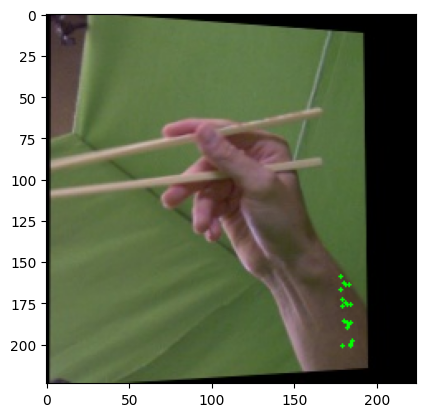

In [31]:
val_id = 4
image_name, relative_points = dataset["test"][val_id]
image = Image.open(image_name).convert('RGB')
image = np.asarray(image)
pred = model(train_dataset.preprocessing(image=image)['image'].unsqueeze(0).to(device))
pred = pred.cpu().detach().numpy()[0]

height, width, _ = image.shape

points = pred.reshape(-1, 2)

for x, y in points:
    x = int(x)
    y = int(y)
    cv2.circle(image, (x, y), 0, (0, 255, 0), 2)
plt.imshow(image)

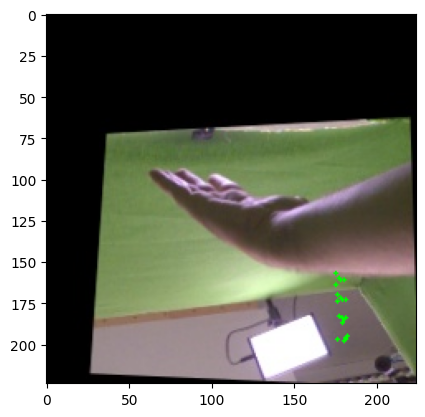

In [36]:
val_id = 11
image_name, relative_points = dataset["test"][val_id]
image = Image.open(image_name).convert('RGB')
image = np.asarray(image)
pred = model(train_dataset.preprocessing(image=image)['image'].unsqueeze(0).to(device))
pred = pred.cpu().detach().numpy()[0]

height, width, _ = image.shape

points = pred.reshape(-1, 2)

for x, y in points:
    x = int(x)
    y = int(y)
    cv2.circle(image, (x, y), 0, (0, 255, 0), 2)
plt.imshow(image)

# Сравнение с другими моделями

In [37]:
test_dataset = KeypointsDataset(meta=dataset["test"])
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [40]:
model.eval()
        
val_predictions = []
val_targets = []
for batch, targets in test_dataloader:

    with torch.no_grad():

        batch = batch.to(device)
        targets = targets.to(device)
        predictions = model(batch)

        predictions = predictions.cpu().numpy().reshape(-1, 3)
        val_predictions.extend(predictions)
        targets = targets.cpu().numpy().reshape(-1, 3)
        val_targets.extend(targets)

val_targets.append(val_targets)
val_predictions.append(val_predictions)

In [48]:
val_targets = [list(i) for i in val_targets]

In [50]:
val_targets = [x for y in val_targets for x in y]

In [51]:
val_predictions = [list(i) for i in val_predictions]
val_predictions = [x for y in val_predictions for x in y]

In [74]:
val_predictions = val_predictions[:200000]
val_targets = val_targets[:200000]

## Метрика -- MSE

In [59]:
from sklearn.metrics import mean_squared_error

In [80]:
mse_own_model = mean_squared_error(val_targets, val_predictions)

In [82]:
import mediapipe as mp

In [83]:
mp_model = mp.solutions.hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [111]:
true_values, mediapipe_preds = [], []
for im_path, points in tqdm(dataset["test"]):
    
    image = cv2.imread(im_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(image_rgb, (224, 224), interpolation = cv2.INTER_AREA)
    results = mp_model.process(image_rgb)
    if results.multi_hand_landmarks:
        results_xy = []
        for hand_landmarks in results.multi_hand_landmarks:
            for landmark in hand_landmarks.landmark:
                results_xy.append(landmark.x)
                results_xy.append(landmark.y)
        mediapipe_preds.append(results_xy)
        
        y_true = [x for y in points for x in y]
        true_values.append(y_true)

100%|██████████| 3256/3256 [01:46<00:00, 30.48it/s]


In [113]:
tr = [x for y in true_values for x in y]

In [114]:
pr = [x for y in mediapipe_preds for x in y]

In [116]:
mediapipe_MSE = mean_squared_error(tr, pr)

In [117]:
print(f"MSE нашей модели: {mse_own_model}")
print(f"MSE mediapipe: {mediapipe_MSE}")

MSE нашей модели: 3486.441162109375
MSE mediapipe: 0.003327881874557315


Такие дела...